In [10]:
# %load_ext autoreload
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
import os

if os.path.basename(os.getcwd()) == "analysis":
    os.chdir("..")

# %autoreload 2  # autoreload probably not working in vscode

In [11]:
!cd

c:\Users\Laboratorio IA\Desktop\interpretability_experiments


In [12]:
import pickle

pickle_file = "ac_2last_states.pkl"

with open(pickle_file, "rb") as f:
    data = pickle.load(f)

In [13]:
data

[{0: {'wins': 2, 'losses': 2, 'draws': 0}},
 {0: {'wins': 4, 'losses': 0, 'draws': 0},
  1: {'wins': 0, 'losses': 4, 'draws': 0}},
 {0: {'wins': 4, 'losses': 0, 'draws': 0},
  1: {'wins': 4, 'losses': 0, 'draws': 0},
  2: {'wins': 4, 'losses': 0, 'draws': 0}},
 {0: {'wins': 4, 'losses': 0, 'draws': 0},
  1: {'wins': 4, 'losses': 0, 'draws': 0},
  2: {'wins': 4, 'losses': 0, 'draws': 0},
  3: {'wins': 2, 'losses': 2, 'draws': 0}},
 {0: {'wins': 4, 'losses': 0, 'draws': 0},
  1: {'wins': 4, 'losses': 0, 'draws': 0},
  2: {'wins': 4, 'losses': 0, 'draws': 0},
  3: {'wins': 4, 'losses': 0, 'draws': 0},
  4: {'wins': 2, 'losses': 2, 'draws': 0}},
 {0: {'wins': 4, 'losses': 0, 'draws': 0},
  1: {'wins': 2, 'losses': 2, 'draws': 0},
  2: {'wins': 2, 'losses': 2, 'draws': 0},
  3: {'wins': 2, 'losses': 2, 'draws': 0},
  4: {'wins': 2, 'losses': 2, 'draws': 0},
  5: {'wins': 2, 'losses': 2, 'draws': 0}},
 {0: {'wins': 3, 'losses': 1, 'draws': 0},
  1: {'wins': 2, 'losses': 2, 'draws': 0},
  2: 

In [14]:
results_vs_rival

{'wins': 4, 'losses': 0, 'draws': 0}

In [15]:
import numpy as np
import pandas as pd

data
n_epochs = len(data)
total = 300

df = pd.DataFrame()
win_rate = np.full((n_epochs, n_epochs), np.nan)
unilateral = np.full((n_epochs, n_epochs), np.nan)
for epoch, results_epoch in enumerate(data):
    for rival_epoch, results_vs_rival in results_epoch.items():
        _in_favor = results_vs_rival["wins"] + (results_vs_rival["draws"]) * 0.5
        in_contra = results_vs_rival["losses"] + (results_vs_rival["draws"]) * 0.5

        win_rate[epoch, rival_epoch] = _in_favor
        unilateral[epoch, rival_epoch] = _in_favor
        # assert _in_favor + in_contra == total
        win_rate[rival_epoch, epoch] = in_contra
        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    [
                        {
                            "Excerpt A": epoch,
                            "Excerpt B": rival_epoch,
                            "Wins A": _in_favor,
                            "Wins B": in_contra,
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )

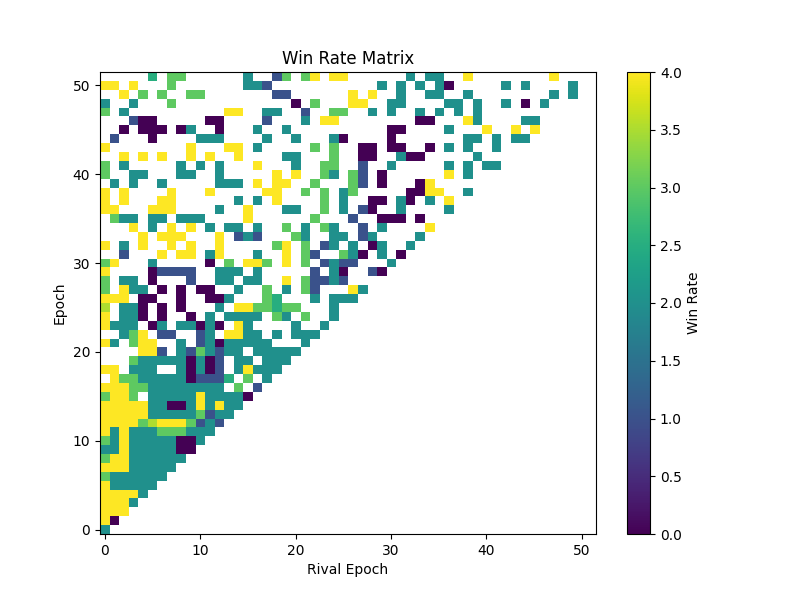

In [16]:
import matplotlib.pyplot as plt

%matplotlib widget

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(unilateral, aspect="auto", origin="lower", cmap="viridis")
fig.colorbar(cax, label="Win Rate")
ax.set_xlabel("Rival Epoch")
ax.set_ylabel("Epoch")
ax.set_title("Win Rate Matrix")
plt.show()

In [17]:
win_rate_by_epoch = np.nanmean(unilateral, axis=1) / total
win_rate_rivals = (total - np.nanmean(unilateral, axis=0)) / total
win_rate_rivals

C:\Users\Laboratorio IA\AppData\Local\Temp\ipykernel_30640\4118875487.py:2: RuntimeWarning: Mean of empty slice
  win_rate_rivals = (total - np.nanmean(unilateral, axis=0)) / total


array([0.98815315, 0.98962963, 0.98969697, 0.99150538, 0.99229885,
       0.99402299, 0.99298851, 0.99130435, 0.99423077, 0.99373333,
       0.99350877, 0.99478261, 0.99426667, 0.99177083, 0.99133333,
       0.99145833, 0.99245614, 0.99238095, 0.99133333, 0.99083333,
       0.99272727, 0.99166667, 0.99272727, 0.99181818, 0.99176471,
       0.99388889, 0.99121212, 0.99636364, 0.99666667, 0.99703704,
       0.99666667, 0.996     , 0.99733333, 0.9975    , 0.9925    ,
       0.992     , 0.9925    , 0.99333333, 0.99166667, 0.99333333,
       0.99      , 0.99333333, 0.99333333, 0.99      , 0.995     ,
       0.99      , 0.99333333, 0.99      ,        nan, 0.99333333,
              nan,        nan])

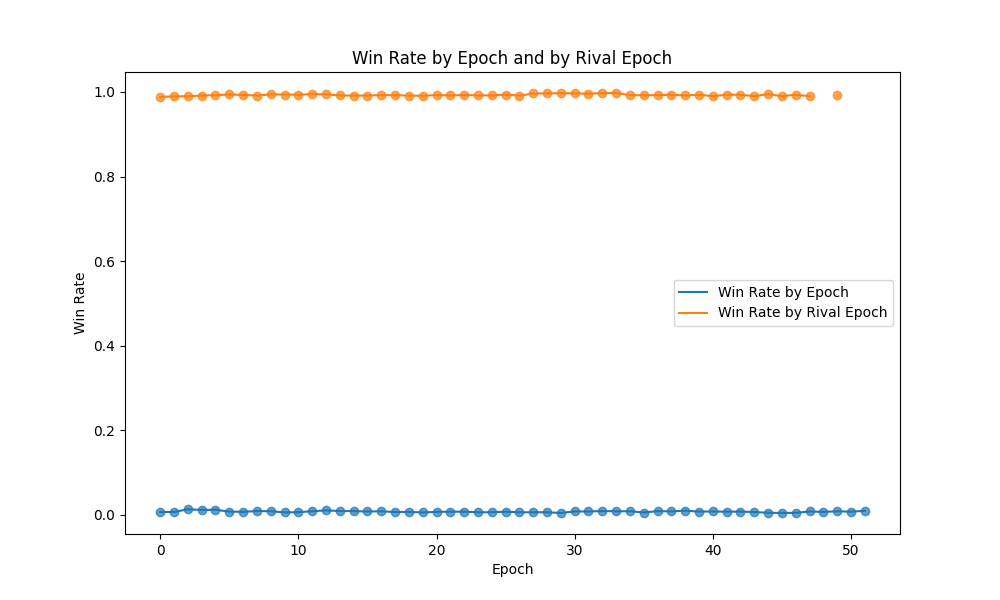

In [18]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(win_rate_by_epoch, label="Win Rate by Epoch")
ax2.plot(win_rate_rivals, label="Win Rate by Rival Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Win Rate")
ax2.set_title("Win Rate by Epoch and by Rival Epoch")
ax2.legend()
ax2.scatter(
    range(len(win_rate_by_epoch)),
    win_rate_by_epoch,
    label="Win Rate by Epoch (scatter)",
    color="tab:blue",
    alpha=0.7,
)
ax2.scatter(
    range(len(win_rate_rivals)),
    win_rate_rivals,
    label="Win Rate by Rival Epoch (scatter)",
    color="tab:orange",
    alpha=0.7,
)
plt.show()

In [19]:
from collections import Counter

import logging
import numpy as np
import os
import pandas as pd
import time

# import plotly.express as px

from datetime import datetime
from collections import Counter
from itertools import combinations, combinations_with_replacement, permutations


def bradley_terry_analysis(text_data, max_iters=1000, error_tol=1e-3):
    """Computes Bradley-Terry using iterative algorithm
    See: https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model
    """
    # Do some aggregations for convenience
    # Total wins per excerpt
    winsA = text_data.groupby("Excerpt A").agg(sum)["Wins A"].reset_index()
    winsA = winsA[winsA["Wins A"] > 0]
    winsA.columns = ["Excerpt", "Wins"]
    winsB = text_data.groupby("Excerpt B").agg(sum)["Wins B"].reset_index()
    winsB = winsB[winsB["Wins B"] > 0]
    winsB.columns = ["Excerpt", "Wins"]
    wins = pd.concat([winsA, winsB]).groupby("Excerpt").agg(sum)["Wins"]

    # Total games played between pairs
    num_games = Counter()
    for index, row in text_data.iterrows():
        key = tuple(sorted([row["Excerpt A"], row["Excerpt B"]]))
        total = sum([row["Wins A"], row["Wins B"]])
        num_games[key] += total

    # Iteratively update 'ranks' scores
    excerpts = sorted(list(set(text_data["Excerpt A"]) | set(text_data["Excerpt B"])))
    ranks = pd.Series(np.ones(len(excerpts)) / len(excerpts), index=excerpts)
    for iters in range(max_iters):
        oldranks = ranks.copy()
        for excerpt in ranks.index:
            denom = np.sum(
                num_games[tuple(sorted([excerpt, p]))] / (ranks[p] + ranks[excerpt])
                for p in ranks.index
                if p != excerpt
            )
            ranks[excerpt] = 1.0 * wins[excerpt] / denom

        ranks /= sum(ranks)

        if np.sum((ranks - oldranks).abs()) < error_tol:
            break

    if np.sum((ranks - oldranks).abs()) < error_tol:
        logging.info(" * Converged after %d iterations.", iters)
    else:
        logging.info(" * Max iterations reached (%d iters).", max_iters)

    # Note we can control scaling here. For this competiton we have -'ve and positive values on the scale
    # To reproduce the results from example; I choose to multiply the rank with x100
    ranks = ranks.sort_values(ascending=False).apply(lambda x: x * 100).round(2)

    return ranks

In [20]:
import pandas as pd

scores = bradley_terry_analysis(df)
scores

C:\Users\Laboratorio IA\AppData\Local\Temp\ipykernel_30640\4256533727.py:22: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  winsA = text_data.groupby("Excerpt A").agg(sum)["Wins A"].reset_index()
C:\Users\Laboratorio IA\AppData\Local\Temp\ipykernel_30640\4256533727.py:25: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  winsB = text_data.groupby("Excerpt B").agg(sum)["Wins B"].reset_index()
C:\Users\Laboratorio IA\AppData\Local\Temp\ipykernel_30640\4256533727.py:28: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callabl

32    4.68
33    4.48
51    4.05
31    3.36
49    3.28
38    3.11
30    3.03
12    2.82
34    2.64
11    2.49
41    2.45
36    2.45
27    2.41
42    2.29
37    2.26
8     2.16
28    2.04
47    1.94
20    1.91
25    1.91
29    1.90
39    1.90
22    1.88
50    1.86
5     1.82
40    1.79
16    1.79
48    1.73
21    1.70
13    1.67
9     1.56
44    1.50
10    1.48
14    1.48
6     1.47
4     1.46
43    1.45
17    1.43
15    1.43
23    1.32
18    1.31
7     1.30
24    1.23
26    1.21
35    1.16
19    1.15
3     1.03
46    1.00
45    0.92
2     0.63
1     0.45
0     0.22
dtype: float64

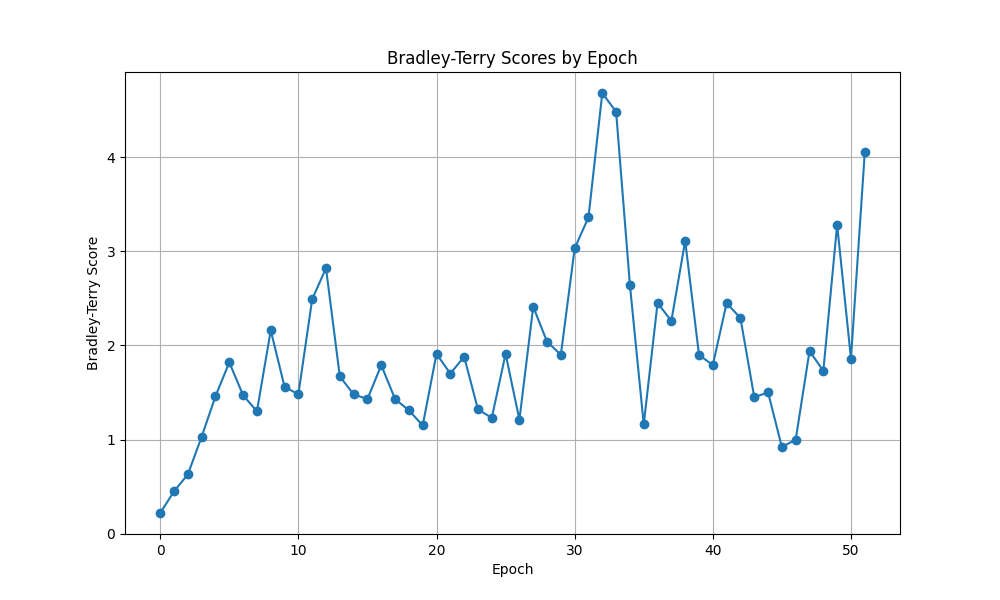

In [21]:
plt.figure(figsize=(10, 6))
scores.sort_index().plot(marker="o")
plt.xlabel("Epoch")
plt.ylabel("Bradley-Terry Score")
plt.title("Bradley-Terry Scores by Epoch")
plt.grid(True)
plt.show()